In [2]:
import networkx as nx
import pandas as pd
import seaborn as sn
import matplotlib.pyplot as plt
import random
import numpy as np
import math
from bisect import bisect

In [3]:
import matplotlib as mpl

mpl.rcParams['figure.figsize'] = [12.0, 7.0]
mpl.rcParams['figure.dpi'] = 100

In [4]:
from utils.data_spit import data_split

from generators.LFR import LFR
from generators.OLP import OLP

In [5]:
# hyperparameters

seed = random.randint(1, 1000)                              # random seed

# GRAPH PARAMETERS
N = 5000                                                   # synthetic graph size

# CLASSIFIER PARAMETERS
quality_class_intervals = [0, 0.25, 0.50, 0.75, 1.001]      # quality class intervals
quality_class_labels = [0, 1, 2, 3]                         # quality class labels
quality_class_names = ['exelent', 'good', 'ok', 'poor']     # quality classes names

# Step 1
## Graph and features generation

Generate/import graph and features based on avalible `generator` classes

In [6]:
generator = LFR(n=N, seed=seed)
#generator = OLP()

ground_truth_df = generator.get_df()

features_df = generator.get_features_df()
feature_names = generator.feature_names

print(feature_names)

['RAI', 'JC', 'AAI', 'PA']


In [7]:
ground_truth_df['goal'].value_counts()

1    5125
0    5125
Name: goal, dtype: int64

In [8]:
features_df.head(5)

,node1,node2,RAI,JC,AAI,PA
10946950,3243,4348,0.0,0.0,0.0,0.003574
11927878,3941,4344,0.0,0.0,0.0,0.005956
8626771,2219,4225,0.0,0.0,0.0,0.044074
2173975,456,481,0.0,0.0,0.0,0.005360
2326331,489,3586,0.0,0.0,0.0,0.025015


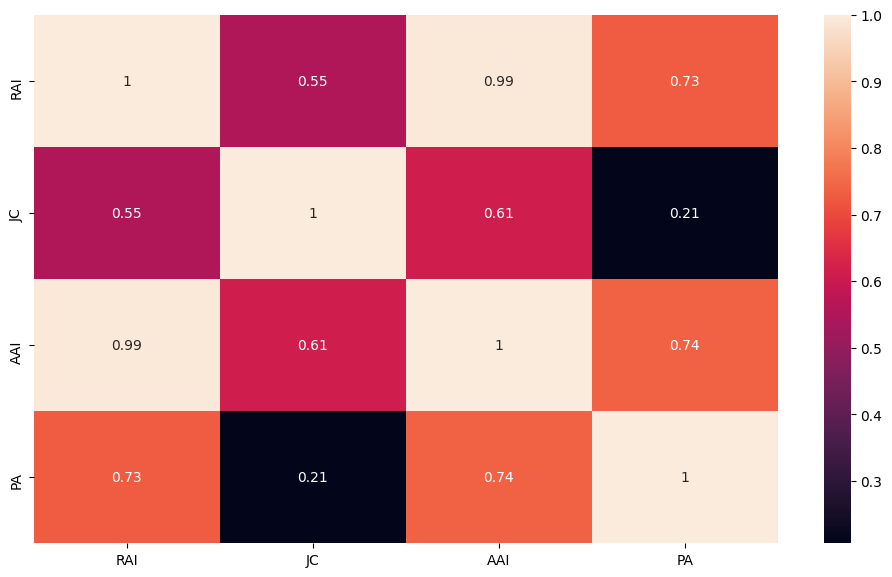

In [9]:
corrMatrix = features_df[['RAI', 'JC', 'AAI', 'PA']].corr()
sn.heatmap(corrMatrix, annot=True)
plt.show()

# Step 2
## Splitting the data

We split the data in the following way:
* 1/3 is used to train a link prediction model
* 1/3 is used to test the link prediction model. Here we also calculate the error and use this data to train quality classifier
* 1/3 is used to evaluate the clasifier

In [10]:
link_prediction_train, link_prediction_test, classifier_test = data_split(ground_truth_df, features_df)

In [11]:
link_prediction_train['goal'].value_counts()

1    1706
0    1706
Name: goal, dtype: int64

In [12]:
link_prediction_test['goal'].value_counts()

1    1706
0    1706
Name: goal, dtype: int64

In [13]:
classifier_test['goal'].value_counts()

1    1706
0    1706
Name: goal, dtype: int64

# Step 4
## Link prediction model

In [14]:
# LINK PREDICTION BASED ON THE TOPOLOGICAL FEATURES

from sklearn.ensemble import RandomForestClassifier

# random forest classification
forest = RandomForestClassifier(random_state=seed)
forest.fit(link_prediction_train[feature_names], link_prediction_train['goal'])

# predicting edge existace on features
prob = forest.predict_proba(link_prediction_test[feature_names])[:, 1]
prob = pd.Series(prob, name='prob')

link_proba = link_prediction_train.join(prob)
link_proba.head(5)

,node1,node2,goal,RAI,JC,AAI,PA,prob
0,199,2636,0,0.0,0.0,0.0,0.005360,0.312766
1,3228,4725,0,0.0,0.0,0.0,0.026802,0.312766
2,468,2853,0,0.0,0.0,0.0,0.005956,0.398008
3,808,3215,0,0.0,0.0,0.0,0.005360,0.545430
4,606,4311,0,0.0,0.0,0.0,0.005360,0.233950


In [15]:
print(f'Accuracy score on {len(link_prediction_test)} test samples:')
print(forest.score(link_prediction_test[feature_names], link_prediction_test['goal']))

Accuracy score on 3412 test samples:
0.7072098475967175


In [16]:
# random forest feature importance based on feature permutation

from sklearn.inspection import permutation_importance


show_feature_importance = False

if show_feature_importance:
    result = permutation_importance(forest, link_prediction_test[feature_names],  link_prediction_test['goal'], n_repeats=10, random_state=seed, n_jobs=2)
    forest_importances = pd.Series(result.importances_mean, index=feature_names)
    print('Feature importance based on mean accuracy decrease\n')
    print(forest_importances.to_markdown())

    fig, ax = plt.subplots()
    forest_importances.plot.bar(yerr=result.importances_std, ax=ax)
    ax.set_title("Feature importances based on permutation on full model")
    ax.set_ylabel("Mean accuracy decrease")
    fig.tight_layout()
    plt.show()

# Step 4
## Quality class analisys

In [17]:
from bisect import bisect

def quality_class_label(error): 
    return bisect(quality_class_intervals, error) - 1

In [18]:
# absolute eroor of prediction
link_proba['abs_error'] = link_proba.apply(lambda row: math.fabs(row['goal']-row['prob']), axis=1)
link_proba['quality_label'] = link_proba.apply(lambda row: quality_class_label(row['abs_error']), axis=1)
link_proba['quality_name'] = link_proba.apply(lambda row: quality_class_names[quality_class_label(row['abs_error'])], axis=1)
link_proba.head(5)

,node1,node2,goal,RAI,JC,AAI,PA,prob,abs_error,quality_label,quality_name
0,199,2636,0,0.0,0.0,0.0,0.005360,0.312766,0.312766,1,good
1,3228,4725,0,0.0,0.0,0.0,0.026802,0.312766,0.312766,1,good
2,468,2853,0,0.0,0.0,0.0,0.005956,0.398008,0.398008,1,good
3,808,3215,0,0.0,0.0,0.0,0.005360,0.545430,0.545430,2,ok
4,606,4311,0,0.0,0.0,0.0,0.005360,0.233950,0.233950,0,exelent


In [19]:
# statistics on error
link_proba['abs_error'].describe()

count    3412.000000
mean        0.363728
std         0.231716
min         0.000000
25%         0.233950
50%         0.407133
75%         0.553260
max         1.000000
Name: abs_error, dtype: float64

Text(0, 0.5, 'Number of node pairs')

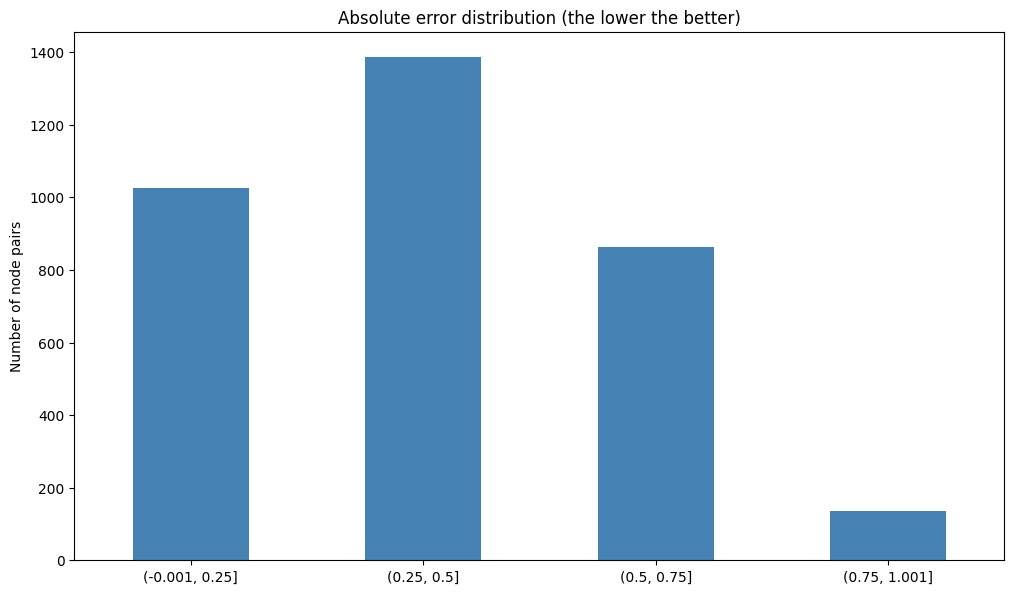

In [20]:
# plot error distribution
fig, ax = plt.subplots()

pd.cut(link_proba['abs_error'], bins=quality_class_intervals, include_lowest=True).value_counts(sort=False).plot.bar(rot=0, color='steelblue', ax=ax)
#ax.set_xticks(np.add(quality_class_labels, 0))
#ax.set_xticklabels(quality_class_names)
ax.set_title("Absolute error distribution (the lower the better)")
ax.set_ylabel("Number of node pairs")

# Step 5
## Quality class prediction

In [21]:
# train for quality class prediction

from sklearn.linear_model import LogisticRegression

#clf = LogisticRegression(random_state=seed, class_weight='balanced')
clf = LogisticRegression(random_state=seed)
clf.fit(link_proba[feature_names], link_proba['quality_label'])

LogisticRegression(random_state=537)

In [22]:
# testing the classifier

pred = clf.predict(classifier_test[feature_names])
pred = pd.Series(pred, name='predicted_quality_label')

proba = clf.predict_proba(classifier_test[feature_names])[:, 1]
proba = pd.Series(proba, name='prob')

classifier_test = classifier_test.join(proba)
classifier_test = classifier_test.join(pred)

classifier_test['true_abs_error'] = classifier_test.apply(lambda row: math.fabs(row['goal']-row['prob']), axis=1)
classifier_test['true_quality_label'] = classifier_test.apply(lambda row: quality_class_label(row['true_abs_error']), axis=1)
classifier_test.head(5)

,node1,node2,goal,RAI,JC,AAI,PA,prob,predicted_quality_label,true_abs_error,true_quality_label
0,96,1171,0,0.0,0.0,0.0,0.009529,0.476624,1,0.476624,1
1,2015,2237,0,0.0,0.0,0.0,0.002382,0.481200,1,0.481200,1
2,667,2827,0,0.0,0.0,0.0,0.020846,0.469386,1,0.469386,1
3,324,3522,0,0.0,0.0,0.0,0.004765,0.479674,1,0.479674,1
4,1637,4030,0,0.0,0.0,0.0,0.005360,0.479293,1,0.479293,1


In [23]:
classifier_test[['true_quality_label']].value_counts()

true_quality_label
1                     1698
2                     1090
3                      616
0                        8
dtype: int64

In [27]:
classifier_test[['predicted_quality_label']].value_counts()

predicted_quality_label
1                          2738
2                           429
0                           245
dtype: int64

In [24]:
score = clf.score(classifier_test[feature_names], classifier_test['true_quality_label'])
print(f'Accuracy score on {len(classifier_test)} test samples is {score}')

Accuracy score on 3412 test samples is 0.5008792497069168


In [25]:
from sklearn import metrics

y_true, y_pred = classifier_test['true_quality_label'], classifier_test['predicted_quality_label']

print(metrics.precision_score(y_true, y_pred, average='macro'))
print(metrics.recall_score(y_true, y_pred, average='micro'))
print(metrics.f1_score(y_true, y_pred, average='weighted'))

0.1627634044622462
0.5008792497069168
0.3844028701868415


/Users/andrejantonov/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


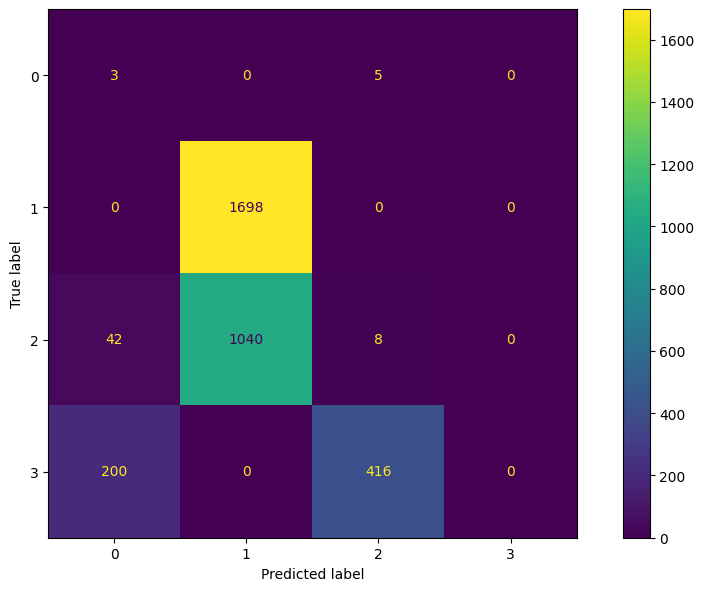

In [26]:
metrics.plot_confusion_matrix(clf, classifier_test[feature_names], classifier_test['true_quality_label'])